In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
# load numpy array from npy file
from numpy import load
# load array
dset1 = load('files/gamma_image.npy')
dset2 = load('files/electron_image.npy')
dset3 = load('files/proton_image.npy')
dset4 = load('files/helium_image.npy')
dset5 = load('files/nitrogen_image.npy')
dset6 = load('files/iron_image.npy')
dset7 = load('files/silicon_image.npy')

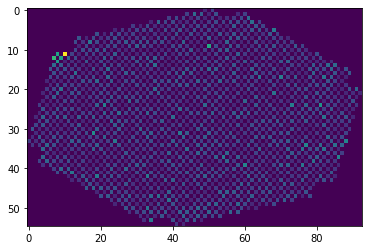

In [3]:
import matplotlib.pyplot as plt
plt.imshow(dset6[2], interpolation='none',aspect='auto')
fig_size = plt.rcParams["figure.figsize"]
plt.show()

### split data

In [4]:
%%time
# tot=0
# for i in range (1,8):
#     tot=tot+(eval('dset'+str(i)).shape)[0]

target0=np.zeros(dset1.shape[0]) #esto es gamma
target1=np.ones(dset2.shape[0]+dset3.shape[0]+dset4.shape[0]+dset5.shape[0]+dset6.shape[0]+dset7.shape[0])
target=np.concatenate((target0, target1), axis=0)
#put the dataset together
data=np.concatenate((dset1,dset2,dset3,dset4,dset5,dset6,dset7),axis=0)

Wall time: 2.26 s


In [5]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=2)  

In [6]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# input image dimensions
imgRows, imgCols = 55, 93
numChannels=1
samples=X_train.shape[0]
numClasses=2

x_train=X_train
x_test=X_test
#PARA PONER LOS CANALES AL PPO
# x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
# x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
# input_shape = (1, img_rows, img_cols)

x_train = x_train.reshape(x_train.shape[0], imgRows, imgCols, 1)
x_test = x_test.reshape(x_test.shape[0], imgRows, imgCols, 1)
input_shape = (imgRows, imgCols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


Using TensorFlow backend.


## NN

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(numClasses, activation=tf.nn.softmax))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model.fit(X_train, y_train, epochs=1, validation_data=(x_test, y_test)) #epochs es el numero de iteraciones hasta alcanzar un loss minimo

Train on 22155 samples, validate on 5539 samples
22155/22155 [==============================] - 5s 239us/sample - loss: 0.0306 - accuracy: 0.9968 - val_loss: 0.0125 - val_accuracy: 0.9971


In [10]:
val_loss, val_acc = model.evaluate(X_test, y_test)
# print(val_loss)
print(val_acc)
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

5539/5539 [==============================] - 0s 88us/sample - loss: 0.0111 - accuracy: 0.9971
0.9971114
[[2425    6]
 [  10 3098]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2431
         1.0       1.00      1.00      1.00      3108

    accuracy                           1.00      5539
   macro avg       1.00      1.00      1.00      5539
weighted avg       1.00      1.00      1.00      5539



# build model

In [11]:
def create_model(stride=2,pool=2,filters=20,kernel=5,hidden_layers=1,neurons=128,optimizer='adam',
                 learn_rate=0.001, init_mode='glorot_uniform', activation='relu', dropout_rate=0.2,
                 weight_constraint=0):#parameters here are default
    #create model
    
    #los weight_initializer son mas optimos dependiendo de la funcion de activacion
   # initialize the model
    model = Sequential()
    inputShape = (imgRows, imgCols,numChannels)                                                                        
    # define the first set of CONV => ACTIVATION => POOL layers
    model.add(Conv2D(filters, kernel, padding="same",input_shape=inputShape, activation=activation))
    model.add(MaxPooling2D(pool_size=(pool, pool), strides=(stride, stride)))  
    # define the second set of CONV => ACTIVATION => POOL layers
    model.add(Conv2D(int(round(filters*5/2)), kernel, padding="same", activation=activation))
    model.add(MaxPooling2D(pool_size=(pool, pool), strides=(stride, stride)))
    # define the first FC => ACTIVATION layers
    
    model.add(Flatten())
    for i in range(hidden_layers):
        model.add(Dense(neurons,kernel_initializer=init_mode,  activation=activation)) 
        #model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))    #, use_bias=False
        #model.add(Dropout(dropout_rate)) 
    # lastly, define the soft-max classifier
    model.add(Dense(numClasses, activation='softmax'))
  
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])              

    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [12]:
shape=x_train.shape
model=create_model()
model.build(shape) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 55, 93, 20)        520       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 46, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 46, 50)        25050     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 23, 50)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14950)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1913728   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [79]:
%%time
model=create_model()
history=model.fit(x_train, y_train, epochs=1,batch_size=128, validation_data=(x_test, y_test))

Train on 22076 samples, validate on 5519 samples
Epoch 1/1
22076/22076 [==============================] - 219s 10ms/step - loss: 0.0385 - accuracy: 0.9917 - val_loss: 0.0128 - val_accuracy: 0.9978
Wall time: 3min 41s


In [80]:
val_loss, val_acc = model.evaluate(x_test, y_test)
# print(val_loss)
print(val_acc)
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict_classes(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

5519/5519 [==============================] - 15s 3ms/step
0.9978256821632385
[[2419    2]
 [  10 3088]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2421
         1.0       1.00      1.00      1.00      3098

    accuracy                           1.00      5519
   macro avg       1.00      1.00      1.00      5519
weighted avg       1.00      1.00      1.00      5519

